## The goal: Get coupling indices on monthly time scales. Use these and compare against daily ones - how key is it? 
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 29 Sept 2020 <br><br>

In [1]:
## Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
import regionmask
from ComputeLCLpressure_function import ComputeLCLpressure

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


In [3]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


# Compute coupling indices using monthly data

## CESM2 
* Read in monthly files 
* Compute coupling index 


In [85]:
# Begin to set up file names 
cesm2dir   = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/data/Monthly/CESM2/'

middleName = '_Amon_CESM2_amip_r10i1p1f1_gn_'

varNames   = ['hfls','hfss','hurs','mrsos','ps','tas']

timeNames  = ['195001-199912', '200001-201412']


In [86]:
# Read in test file to get lat/lon 
fileName = cesm2dir+varNames[0]+middleName+timeNames[0]+'.nc'
testDF   = xr.open_dataset(fileName, decode_times=True)

# Get lat and lon 
lat = testDF.lat.values
lon = testDF.lon.values 


/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'hfls' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [87]:
# Read in variables

for iT in range(len(timeNames)):

    # --- Compile surface fluxes into singe large arrays in time 

    # Latent heat flux
    lhFile       = cesm2dir+'hfls'+middleName+timeNames[iT]+'.nc' # File name
    lhDF         = xr.open_dataset(lhFile,decode_times=True) 
    lhDF['time'] = lhDF.indexes['time'].to_datetimeindex()

    # Sensible heat flux
    shFile       = cesm2dir+'hfss'+middleName+timeNames[iT]+'.nc' # File name
    shDF         = xr.open_dataset(shFile,decode_times=True)
    shDF['time'] = shDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    # 10 cm soil moisture 
    smFile       = cesm2dir+'mrsos'+'_Lmon_CESM2_amip_r10i1p1f1_gn_'+timeNames[iT]+'.nc'
    soilDF       = xr.open_dataset(smFile,decode_times=True)
    soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
    
    # --- Compile surface T and RH into large arrays 

    # Sfc Temp
    tFile          = cesm2dir+'tas'+middleName+timeNames[iT]+'.nc' # File name
    TsfcDF         = xr.open_dataset(tFile,decode_times=True) 
    TsfcDF['time'] = TsfcDF.indexes['time'].to_datetimeindex()

    # Sfc RH
    rhFile       = cesm2dir+'hurs'+middleName+timeNames[iT]+'.nc' # File name
    rhDF         = xr.open_dataset(rhFile,decode_times=True)
    rhDF['time'] = rhDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    # Sfc pressure
    psFile       = cesm2dir+'ps'+middleName+timeNames[iT]+'.nc' # File name
    psDF         = xr.open_dataset(psFile,decode_times=True)
    psDF['time'] = psDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    if iT==0:
        lhflx_full = lhDF 
        shflx_full = shDF
        Tsfc_full  = TsfcDF 
        RHsfc_full = rhDF
        Psfc_full  = psDF
        soilM10_full = soilDF
    else: 
        lhflx_full = xr.concat([lhflx_full, lhDF], dim="time")
        shflx_full = xr.concat([shflx_full, shDF], dim="time")
        Tsfc_full  = xr.concat([Tsfc_full,  TsfcDF], dim="time")
        RHsfc_full = xr.concat([RHsfc_full, rhDF],   dim="time")
        Psfc_full  = xr.concat([Psfc_full,  psDF],   dim="time")
        soilM10_full = xr.concat([soilM10_full, soilDF], dim="time")
        
    print('Done with files for times: ', timeNames[iT])



<ipython-input-87-d96e5095ed3c>:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  lhDF['time'] = lhDF.indexes['time'].to_datetimeindex()
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/conventions.py:490: SerializationWarning: variable 'hfss' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
<ipython-input-87-d96e5095ed3c>:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  shDF['time'] = shDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to da

Done with files for times:  195001-199912
Done with files for times:  200001-201412


In [15]:
Psfc_full

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 780)
Coordinates:
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time       (time) datetime64[ns] 1950-01-15T12:00:00 ... 2014-12-15T12:00:00
Dimensions without coordinates: nbnd
Data variables:
    ps         (time, lat, lon) float32 68229.79 68229.79 ... 101684.77
    time_bnds  (time, nbnd) object 1950-01-01 00:00:00 ... 2015-01-01 00:00:00
    lat_bnds   (time, lat, nbnd) float64 -90.0 -89.53 -89.53 ... 89.53 90.0
    lon_bnds   (time, lon, nbnd) float64 -0.625 0.625 0.625 ... 358.1 359.4
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          no parent
    branch_time_in_child:   711385.0
    branch_time_in_parent:  0.0
    case_id:                1587
    cesm_casename:          f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.010
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-11-21T13:11:40Z
    data_specs_version:     01.00.31
    experiment:             An atmosphere only climate simulation using presc...
    experiment_id:          amip
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2.a...
    grid:                   native 0.9x1.25 finite volume grid (192x288 latxlon)
    grid_label:             gn
    initialization_index:   1
    institution:            National Center for Atmospheric Research, Climate...
    institution_id:         NCAR
    license:                CMIP6 model data produced by <The National Center...
    mip_era:                CMIP6
    model_doi_url:          https://doi.org/10.5065/D67H1H0V
    nominal_resolution:     100 km
    parent_activity_id:     no parent
    parent_experiment_id:   no parent
    parent_mip_era:         no parent
    parent_source_id:       no parent
    parent_time_units:      no parent
    parent_variant_label:   no parent
    physics_index:          1
    product:                model-output
    realization_index:      10
    realm:                  atmos
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    source_id:              CESM2
    source_type:            AGCM BGC AER
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/5e323818-5c4c-409d-a097-9c50d225c88e
    variable_id:            ps
    variant_info:           CMIP6 CESM2 AMIP hindcast (1950-2014) with intera...
    variant_label:          r10i1p1f1

In [89]:
# Since files are saved a bit differently for CESM2, just compute manually... 
# --------------------------------------

# Convert temperature to ˚C 
T_degC = Tsfc_full['tas'].values - 273.15

# Get RH as fraction, not %
RH_frac = RHsfc_full['hurs'].values / 100.0 

# Convert surface pressure to hPa 
PS_hPa = Psfc_full['ps'].values / 100.0

# Set number of times:
nT = len(Tsfc_full.time.values)
    
# Compute dew point and P_LCL 
Td   = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in Kelvin
Plcl = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in hPa 

# Define constants for dew point calculation
c1 = 610.94   # [Pa]
a1 = 7.625
b1 = 243.04   # [degC]

for iT in range(np.shape(T_degC)[0]):

    # Compute dewpoint temperature:
    numerator   = b1 * (np.log(RH_frac[iT,:,:]) + ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) )
    denominator = a1 - np.log(RH_frac[iT,:,:]) - ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) 

    Td[iT,:,:] = (numerator/denominator) + 273.15   #Convert to K here too 

    # Compute pressure level of LCL:
    inner        = ((Tsfc_full['tas'].values[iT,:,:] - Td[iT,:,:]) / 223.15) + 1  # Part inside ()
#    Plcl[iT,:,:] = PS_hPa[iT,:,:]*(inner**(-3.5))
    Plcl[iT,:,:] = PS_hPa[iT,:,:] - (PS_hPa[iT,:,:]*(inner**(-3.5)))    # Want to get distance above sfc in mb 

    if (iT % round(nT/10))==0: 
        print('Done with ', (iT/nT)*100, ' % of days')

# Add check to set Plcl to zero if it's negative (below the surface pressure)
Plcl[Plcl<0] = np.nan



Done with  0.0  % of days
Done with  10.0  % of days
Done with  20.0  % of days
Done with  30.0  % of days
Done with  40.0  % of days
Done with  50.0  % of days
Done with  60.0  % of days
Done with  70.0  % of days
Done with  80.0  % of days
Done with  90.0  % of days


### Sanity check some variables

<ipython-input-19-b4d33e04f0d6>:8: RuntimeWarning: Mean of empty slice
  Plcl_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(Plcl,0)), lon)


Text(0.5, 1.0, 'Pressure Level of LCL (time average)')

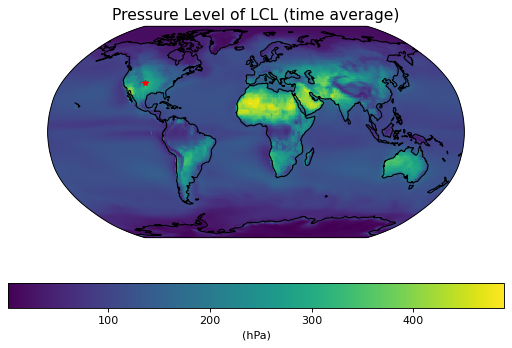

In [19]:
# Map out average pressure level of the LCL (in terms of height above sfc)

fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
Plcl_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(Plcl,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,Plcl_cyclic,transform=ccrs.PlateCarree())
ax.plot(lon_cyclic[206],lat[135],'r*',markersize=5,transform=ccrs.PlateCarree())   # Point for sanity check
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(hPa)',orientation='horizontal')
ax.set_title('Pressure Level of LCL (time average)', fontsize=14)

Text(0.5, 1.0, 'LHFLX (time mean, 1950-2014)')

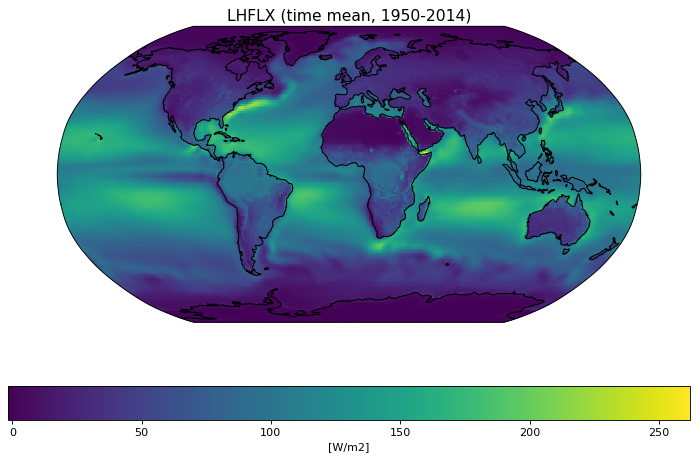

In [21]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
LHavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(lhflx_full.hfls,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,LHavg_cyclic,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[W/m2]',orientation='horizontal')
ax.set_title('LHFLX (time mean, 1950-2014)', fontsize=14)



### Use similar time periods 

In [90]:
# Limit time period of soil moisture: 
dates     = pd.DatetimeIndex(soilM10_full['time'].values)
iInclude  = np.where((dates.year>=1979) & (dates.year<=2006))[0]
dates     = dates[iInclude]

soilM10_sel = np.asarray(soilM10_full.mrsos.values)[iInclude,:,:]
SHflx_sel   = np.asarray(shflx_full.hfss.values)[iInclude,:,:]
LHflx_sel   = lhflx_full.isel(time=iInclude)
Plcl_sel    = Plcl[iInclude,:,:]


### Compute coupling metrics 

In [28]:
# Make one big xr.Dataset containing all the information we need  
dFull_CESM2 = LHflx_sel
dFull_CESM2['soilM_10'] = (('time','lat','lon'), soilM10_sel)
dFull_CESM2['Plcl']     = (('time','lat','lon'), Plcl_sel)
dFull_CESM2['shflx']    = (('time','lat','lon'), SHflx_sel)


In [29]:
# --------------------------------
# Compute CI (SM, LHFLX)
# --------------------------------
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull_CESM2, xname='soilM_10',yname='hfls',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_lhf_vs_soilm_monthlyCESM2.nc')

print('CESM2 CI(SM,LHFLX) file saved!')


/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CESM2 CI(SM,LHFLX) file saved!


In [30]:
# --------------------------------
# Compute CI (SM, SHFLX)
# --------------------------------
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull_CESM2, xname='soilM_10',yname='shflx',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_monthlyCESM2.nc')

print('CESM2 CI(SM,SHFLX) file saved!')



/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CESM2 CI(SM,SHFLX) file saved!


In [31]:
# --------------------------------
# Compute CI (SHFLX, Plcl)
# --------------------------------
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull_CESM2, xname='shflx',yname='Plcl',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_monthlyCESM2.nc')

print('CESM2 CI(SHFLX,Plcl) file saved!')


/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM2 CI(SHFLX,Plcl) file saved!


## CESM1 

In [35]:
cesm1dir = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/data/Monthly/CESM1/'

startCAM   = 'cam5.1_amip_1d_002.cam2.h0.'
startCLM   = 'cam5.1_amip_1d_002.clm2.h0.'

timeNames = ['1979-1989','1990-1999','2000-2006']
endFLX    = '_sfcFluxes.nc'
endSM     = '_monthlySOILWATER10.nc'


In [36]:
# Read in flux files and get time as usable format 
file1 = cesm1dir+startCAM+timeNames[0]+endFLX 
flxDF = xr.open_dataset(file1, decode_times=True)
flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = cesm1dir+startCAM+timeNames[1]+endFLX 
flxDF2 = xr.open_dataset(file2, decode_times=True) 
flxDF2['time'] = flxDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = cesm1dir+startCAM+timeNames[2]+endFLX 
flxDF3 = xr.open_dataset(file3, decode_times=True) 
flxDF3['time'] = flxDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
flux_full  = xr.concat([flxDF,  flxDF2, flxDF3], dim="time")


<ipython-input-36-1fa10d08949f>:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
<ipython-input-36-1fa10d08949f>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  flxDF2['time'] = flxDF2.indexes['time'].to_datetimeindex()
<ipython-input-36-1fa10d08949f>:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between date

File 1 finished reading in...
File 2 finished reading in...
File 3 finished reading in...


In [37]:
# Read in soil moisture files and get time as usable format 
file1 = cesm1dir+'cam5.1_amip_1d_002.clm2.h0.1979-1999_monthlySOILWATER10.nc'
soilDF = xr.open_dataset(file1, decode_times=True)
soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = cesm1dir+'cam5.1_amip_1d_002.clm2.h0.2000-2006_monthlySOILWATER10.nc'
soilDF2 = xr.open_dataset(file2, decode_times=True) 
soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

# Concat in one array 
soilM_full  = xr.concat([soilDF,  soilDF2], dim="time")


<ipython-input-37-285474a6b8ca>:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
<ipython-input-37-285474a6b8ca>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()


File 1 finished reading in...
File 2 finished reading in...


In [48]:
# Use newly created function to get LCL pressure
filesIn = np.asarray([cesm1dir+'cam5.1_amip_1d_002.cam2.h0.1979-1989_refHTs.nc',
                      cesm1dir+'cam5.1_amip_1d_002.cam2.h0.1990-1999_refHTs.nc',
                      cesm1dir+'cam5.1_amip_1d_002.cam2.h0.2000-2006_refHTs.nc'])

fileOutName = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM1.p'
lclPath = ComputeLCLpressure(filesIn,'PS','TREFHT','RHREFHT',fileOutName)

Plcl_CESM1    = pickle.load( open( lclPath, "rb" ) )


Number of files: 

 3
File 1 finished reading in...
File 2 finished reading in...


/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/ComputeLCLpressure_function.py:36: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sfcDF['time'] = sfcDF.indexes['time'].to_datetimeindex()


File 2 concatenated
File 3 finished reading in...
File 3 concatenated
Data starts at:  1979-02-01T00:00:00.000000000
Data ends at:    2006-11-01T00:00:00.000000000
Done with  0.0  % of days
Done with  9.880239520958083  % of days
Done with  19.760479041916167  % of days
Done with  29.64071856287425  % of days
Done with  39.52095808383233  % of days
Done with  49.40119760479042  % of days
Done with  59.2814371257485  % of days
Done with  69.16167664670658  % of days
Done with  79.04191616766467  % of days
Done with  88.92215568862275  % of days
Done with  98.80239520958084  % of days
Finished computing LCL-pressure level successfully and saved pickle file:
/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM1.p


In [57]:
# To be able to easily access years, months, days - use Pandas 
dates_CESM1    = pd.DatetimeIndex(soilM_full['time'].values)


### Sanity check 

(7456.0, 7821.0)

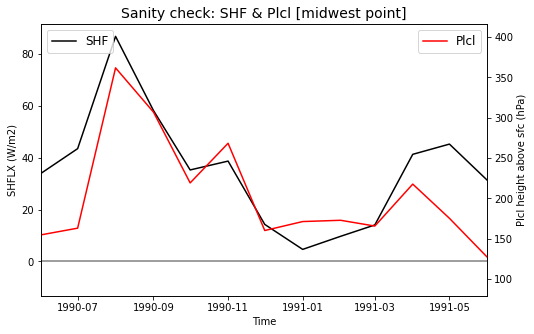

In [60]:
# Plot a timeseries of variables 

fig, ax1 = plt.subplots(1,1, figsize=(8, 5), facecolor='w', edgecolor='k')

ax1.plot(dates_CESM1, flux_full.SHFLX.values[:,135,206],'k-')
ax1.set_ylabel('SHFLX (W/m2)')
ax1.set_xlabel('Time')
ax1.legend(['SHF'],loc='upper left',fontsize=12)
ax1.set_title('Sanity check: SHF & Plcl [midwest point]', fontsize=14)
ax1.axhline(0,color='gray')

ax2 = ax1.twinx()
ax2.plot(dates_CESM1, Plcl_CESM1[:,135,206], 'r-')
ax2.set_ylabel('Plcl height above sfc (hPa)')
ax2.legend(['Plcl'], loc='upper right',fontsize=12)

ax1.set_xlim([datetime.date(1990,6,1), datetime.date(1991,6,1)])



### Times are similar, so compute CI 

In [67]:
# Make one big xr.Dataset containing all the information we need  
dFull_CESM1 = flux_full
dFull_CESM1['soilM_10'] = (('time','lat','lon'), soilM_full.SOILWATER_10CM.values)
dFull_CESM1['Plcl']     = (('time','lat','lon'), Plcl_CESM1)


In [68]:
dFull_CESM1

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 334)
Coordinates:
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time       (time) datetime64[ns] 1979-02-01 1979-03-01 ... 2006-11-01
Dimensions without coordinates: nbnd
Data variables:
    time_bnds  (time, nbnd) object 1979-01-01 00:00:00 ... 2006-11-01 00:00:00
    LHFLX      (time, lat, lon) float32 -0.2001952 -0.07595 ... -0.69054013
    SHFLX      (time, lat, lon) float32 -4.847082 -3.3476732 ... -6.8877435
    soilM_10   (time, lat, lon) float32 91.7 91.7 91.7 91.7 ... nan nan nan nan
    Plcl       (time, lat, lon) float64 6.302 6.867 6.888 6.901 ... nan nan nan
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             cam5.1_amip_1d_002
    title:            UNSET
    logname:          hannay
    host:             be0210en.ucar.ed
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b40_20th_1d_b08c5cn_139jp.cam2.i.1979-01-01-00000.nc
    topography_file:  /fis/cgd/cseg/csm/inputdata/atm/cam/topo/USGS-gtopo30_0...
    history:          Tue Sep 29 08:35:26 2020: ncrcat -v LHFLX,SHFLX cam5.1_...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...

In [70]:
# --------------------------------
# Compute CI (SM, LHFLX)
# --------------------------------
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull_CESM1, xname='soilM_10',yname='LHFLX',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_lhf_vs_soilm_monthlyCESM1.nc')

print('CESM1 CI(SM,LHFLX) file saved!')



/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CESM1 CI(SM,LHFLX) file saved!


In [71]:
# --------------------------------
# Compute CI (SM, SHFLX)
# --------------------------------
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull_CESM1, xname='soilM_10',yname='SHFLX',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_monthlyCESM1.nc')

print('CESM1 CI(SM,SHFLX) file saved!')




/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CESM1 CI(SM,SHFLX) file saved!


In [72]:
# --------------------------------
# Compute CI (SHFLX, Plcl)
# --------------------------------
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull_CESM1, xname='SHFLX',yname='Plcl',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_monthlyCESM1.nc')

print('CESM1 CI(SHFLX,Plcl) file saved!')



/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CESM1 CI(SHFLX,Plcl) file saved!


## CLM4.5

In [75]:
# Set directories for raw data 
clm45Dir = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/data/Monthly/CLM45/'

startCLM = 'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h0.'
startCAM = 'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h0.'

endCLM = '_SOILWATER10CM.nc'
endFLX = '_sfcFluxes.nc'

timeName = ['1976-1989', '1990-1999', '2000-2005']


In [76]:
# Read in flux files and get time as usable format 
file1 = clm45Dir+startCAM+timeName[0]+endFLX 
flxDF = xr.open_dataset(file1, decode_times=True)
flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = clm45Dir+startCAM+timeName[1]+endFLX 
flxDF2 = xr.open_dataset(file2, decode_times=True) 
flxDF2['time'] = flxDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = clm45Dir+startCAM+timeName[2]+endFLX 
flxDF3 = xr.open_dataset(file3, decode_times=True) 
flxDF3['time'] = flxDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
flux_full  = xr.concat([flxDF,  flxDF2, flxDF3], dim="time")



<ipython-input-76-91b822cfdfdb>:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
<ipython-input-76-91b822cfdfdb>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  flxDF2['time'] = flxDF2.indexes['time'].to_datetimeindex()
<ipython-input-76-91b822cfdfdb>:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between date

File 1 finished reading in...
File 2 finished reading in...
File 3 finished reading in...


In [77]:
# Read in soil moisture files and get time as usable format 
file1 = clm45Dir+'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h0.1976-1999_SOILWATER10.nc'
soilDF = xr.open_dataset(file1, decode_times=True)
soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = clm45Dir+'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h0.2000-2005_SOILWATER10.nc'
soilDF2 = xr.open_dataset(file2, decode_times=True) 
soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

# Concat in one array 
soil_full  = xr.concat([soilDF,  soilDF2], dim="time")




<ipython-input-77-f95c2780afbd>:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
<ipython-input-77-f95c2780afbd>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()


File 1 finished reading in...
File 2 finished reading in...


In [80]:
# Use newly created function to get LCL pressure
filesIn = np.asarray([clm45Dir+'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h0.1979-1989_refHTs_RHREFHT.nc',
                      clm45Dir+'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h0.1990-1999_refHTs_RHREFHT.nc',
                      clm45Dir+'f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.cam.h0.2000-2006_refHTs_RHREFHT.nc'])

fileOutName = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-CLM45_monthly.p'

lclPath    = ComputeLCLpressure(filesIn,'PS','TREFHT','RHREFHT',fileOutName)
Plcl_CLM45 = pickle.load( open( lclPath, "rb" ) )

Number of files: 

 3
File 1 finished reading in...
File 2 finished reading in...
File 2 concatenated
File 3 finished reading in...
File 3 concatenated
Data starts at:  1979-02-01T00:00:00.000000000
Data ends at:    2006-01-01T00:00:00.000000000
Done with  0.0  % of days
Done with  9.876543209876543  % of days
Done with  19.753086419753085  % of days
Done with  29.629629629629626  % of days
Done with  39.50617283950617  % of days
Done with  49.382716049382715  % of days
Done with  59.25925925925925  % of days
Done with  69.1358024691358  % of days
Done with  79.01234567901234  % of days
Done with  88.88888888888889  % of days
Done with  98.76543209876543  % of days
Finished computing LCL-pressure level successfully and saved pickle file:
/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM2-CLM45_monthly.p


### Select similar time period

In [94]:
# Limit time period of soil moisture and surface fluxes: 
dates     = pd.DatetimeIndex(soil_full['time'].values)
iInclude  = np.where((dates.year>=1979) & (dates.year<=2006))[0]
# P_lcl is computed starting with Jan average (stored as 1979-02-01), so ignore first time in this data too 
iInclude  = iInclude[1::]

# Select data 
dates     = dates[iInclude]
soilM10_sel = np.asarray(soil_full.SOILWATER_10CM.values)[iInclude,:,:]
flx_sel     = flux_full.isel(time=iInclude)




### Compute CI

In [97]:
# Make one big xr.Dataset containing all the information we need  
dFull_CLM45 = flx_sel
dFull_CLM45['soilM_10'] = (('time','lat','lon'), soilM10_sel)
dFull_CLM45['Plcl']     = (('time','lat','lon'), Plcl_CLM45)


In [98]:
# --------------------------------
# Compute CI (SM, LHFLX)
# --------------------------------
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull_CLM45, xname='soilM_10',yname='LHFLX',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_lhf_vs_soilm_monthlyCLM45.nc')

print('CLM4.5 CI(SM,LHFLX) file saved!')


/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CLM4.5 CI(SM,LHFLX) file saved!


In [99]:
# --------------------------------
# Compute CI (SM, SHFLX)
# --------------------------------
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull_CLM45, xname='soilM_10',yname='SHFLX',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_monthlyCLM45.nc')

print('CLM4.5 CI(SM,SHFLX) file saved!')


/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CLM4.5 CI(SM,SHFLX) file saved!


In [100]:
# --------------------------------
# Compute CI (SHFLX, Plcl)
# --------------------------------
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull_CLM45, xname='SHFLX',yname='Plcl',averaging='season')

# Save to netCDF file
terra_coupling.to_netcdf('/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_monthlyCLM45.nc')

print('CLM4.5 CI(SHFLX,Plcl) file saved!')


/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/meganfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CLM4.5 CI(SHFLX,Plcl) file saved!


# Plot coupling indices from files

## Read in monthly-based coupling indices from files

In [2]:
# Load in pickle files: 
dataDir = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

# ------------------------ CESM2 --------------------------------------
file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_monthlyCESM2.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_monthlyCESM2.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_monthlyCESM2.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CESM2  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CESM2 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CESM2  = xr.open_dataset(dataDir+file_LH,      decode_times=False)

lat = atmoLeg_CESM2.lat.values
lon = atmoLeg_CESM2.lon.values


# ------------------------ CESM1 --------------------------------------
file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_monthlyCESM1.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_monthlyCESM1.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_monthlyCESM1.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CESM1  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CESM1 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CESM1  = xr.open_dataset(dataDir+file_LH,      decode_times=False)


# ------------------------ CLM45 --------------------------------------
file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_monthlyCLM45.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_monthlyCLM45.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_monthlyCLM45.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CLM45  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CLM45 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CLM45  = xr.open_dataset(dataDir+file_LH,      decode_times=False)


# ------------------------ CAM5 --------------------------------------
file_LH      = 'TerraLeg_coupling_lhf_vs_soilm_CESM2-CAM5.nc'
file_TerraSH = 'TerraLeg_coupling_shf_vs_soilm_CESM2-CAM5.nc'
file_AtmoSH  = 'AtmoLeg_coupling_Plcl_vs_shf_CESM2-CAM5.nc'

# Read in coupling indices computed previously (in ExploreData.ipynb)
atmoLeg_CAM5  = xr.open_dataset(dataDir+file_AtmoSH,  decode_times=False)
terraLeg_CAM5 = xr.open_dataset(dataDir+file_TerraSH, decode_times=False)
terraLH_CAM5  = xr.open_dataset(dataDir+file_LH,      decode_times=False)


### Set up color maps

In [4]:
### Create a list of RGB tuples
colorsList_SMvLHF = [(127,58,144), 
                     (67,81,163),
                     (0,191,243),
                     (194,229,220),
                     (124,194,66),
                     (227,219,46),
                     (250,175,44),
                     (245,127,36), 
                     (239,67,54),
                     (238,45,122),
                     (162,6,66)] # This example uses the 8-bit RGB

#colors = [(15,19,135), (9,61,240), (35,93,209), (43,156,222),(90,193,253), 
#           (221,238,247), (246,246,22),(246,186,22),(246,126,22), (246,67,22),(255,24,16)] # This example uses the 8-bit RGB
my_cmap_SMvLHF = make_cmap(colorsList_SMvLHF, bit=True)



### Create a list of RGB tuples for terrestrial leg (SM, SHFLX)
colorsList_SMvSHF = [(124,135,181), 
                     (107,109,161),
                     (51,82,120),
                     (49,114,127),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58)] # This example uses the 8-bit RGB

my_cmap_SMvSHF = make_cmap(colorsList_SMvSHF, bit=True)



### Create a list of RGB tuples for atmospheric leg (SHFLX, P_lcl)
colorsList_SHFvPlcl = [(172,183,209), 
                     (124,135,181),
                     (51,82,120),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58),
                     (136,90,59),
                     (214,48,44),
                     (224,93,126),
                     (242,189,177)] # This example uses the 8-bit RGB

my_cmap_SHFvPlcl = make_cmap(colorsList_SHFvPlcl, bit=True)


## Now make the plots

In [7]:
terraLeg_CESM2

<xarray.Dataset>
Dimensions:            (lat: 192, lon: 288, season: 4)
Coordinates:
  * lon                (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * lat                (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * season             (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    soilM_10_shflx_CI  (season, lat, lon) float64 ...

In [9]:
# --- Define array of colors for maps --- #

# Isolate seasonal arrays (seasons go: DJF,JJA,MAM,SON)
AtmoLeg_JJA_cesm1  = np.squeeze(np.asarray(atmoLeg_CESM1.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_cesm1 = np.squeeze(np.asarray(terraLeg_CESM1.soilM_10_SHFLX_CI[1,:,:]))
AtmoLeg_JJA_cesm2  = np.squeeze(np.asarray(atmoLeg_CESM2.shflx_Plcl_CI[1,:,:]))
TerraLeg_JJA_cesm2 = np.squeeze(np.asarray(terraLeg_CESM2.soilM_10_shflx_CI[1,:,:]))
AtmoLeg_JJA_clm45  = np.squeeze(np.asarray(atmoLeg_CLM45.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_clm45 = np.squeeze(np.asarray(terraLeg_CLM45.soilM_10_SHFLX_CI[1,:,:]))
AtmoLeg_JJA_cam5   = np.squeeze(np.asarray(atmoLeg_CAM5.SHFLX_Plcl_CI[1,:,:]))
TerraLeg_JJA_cam5  = np.squeeze(np.asarray(terraLeg_CAM5.soilM_10_SHFLX_CI[1,:,:]))

# Make cyclic first 
AtmoLeg_JJA_cyclic_cesm1, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_cesm1, lon)
TerraLeg_JJA_cyclic_cesm1, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_cesm1, lon)
AtmoLeg_JJA_cyclic_cesm2, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_cesm2, lon)
TerraLeg_JJA_cyclic_cesm2, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_cesm2, lon)
AtmoLeg_JJA_cyclic_clm45, lon_cyclic  = cartopy.util.add_cyclic_point(AtmoLeg_JJA_clm45, lon)
TerraLeg_JJA_cyclic_clm45, lon_cyclic = cartopy.util.add_cyclic_point(TerraLeg_JJA_clm45, lon)
AtmoLeg_JJA_cyclic_cam5, lon_cyclic   = cartopy.util.add_cyclic_point(AtmoLeg_JJA_cam5, lon)
TerraLeg_JJA_cyclic_cam5, lon_cyclic  = cartopy.util.add_cyclic_point(TerraLeg_JJA_cam5, lon)


# Now get color coded arrays 
colorsAtmoLeg_cesm1  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cesm1 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_cesm2  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cesm2 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_clm45  = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_clm45 = np.full([len(lat),len(lon)+1],np.nan)
colorsAtmoLeg_cam5   = np.full([len(lat),len(lon)+1],np.nan)
colorsTerraLeg_cam5  = np.full([len(lat),len(lon)+1],np.nan)

# ----- CESM 1 ------

# Atmo leg 
colorsAtmoLeg_cesm1[np.where(AtmoLeg_JJA_cyclic_cesm1<-150)]                                 = 1
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-150) & (AtmoLeg_JJA_cyclic_cesm1<=-100))]  = 2
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-100) & (AtmoLeg_JJA_cyclic_cesm1<=-50))]   = 3
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-50)  & (AtmoLeg_JJA_cyclic_cesm1<=-20))]   = 4
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>-20)  & (AtmoLeg_JJA_cyclic_cesm1<=0))]     = 5
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>0)    & (AtmoLeg_JJA_cyclic_cesm1<=20))]    = 6
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>20)   & (AtmoLeg_JJA_cyclic_cesm1<=40))]    = 7
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>40)   & (AtmoLeg_JJA_cyclic_cesm1<=60))]    = 8
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>60)   & (AtmoLeg_JJA_cyclic_cesm1<=80))]    = 9
colorsAtmoLeg_cesm1[np.where((AtmoLeg_JJA_cyclic_cesm1>80)   & (AtmoLeg_JJA_cyclic_cesm1<=100))]   = 10
colorsAtmoLeg_cesm1[np.where(AtmoLeg_JJA_cyclic_cesm1>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cesm1[np.where(TerraLeg_JJA_cyclic_cesm1<-20)]                                 = 1
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-20) & (TerraLeg_JJA_cyclic_cesm1<=-15))]  = 2
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-15) & (TerraLeg_JJA_cyclic_cesm1<=-10))]  = 3
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-10) & (TerraLeg_JJA_cyclic_cesm1<=-5))]   = 4
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-5) & (TerraLeg_JJA_cyclic_cesm1<=-2))]    = 5
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-2) & (TerraLeg_JJA_cyclic_cesm1<=-1))]    = 6
colorsTerraLeg_cesm1[np.where((TerraLeg_JJA_cyclic_cesm1>-1) & (TerraLeg_JJA_cyclic_cesm1<=0))]     = 7
colorsTerraLeg_cesm1[np.where(TerraLeg_JJA_cyclic_cesm1>0)]                                   = 8


# ----- CESM 2 ------

# Atmo leg 
colorsAtmoLeg_cesm2[np.where(AtmoLeg_JJA_cyclic_cesm2<-150)]                                 = 1
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-150) & (AtmoLeg_JJA_cyclic_cesm2<=-100))]  = 2
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-100) & (AtmoLeg_JJA_cyclic_cesm2<=-50))]   = 3
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-50)  & (AtmoLeg_JJA_cyclic_cesm2<=-20))]   = 4
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>-20)  & (AtmoLeg_JJA_cyclic_cesm2<=0))]     = 5
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>0)    & (AtmoLeg_JJA_cyclic_cesm2<=20))]    = 6
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>20)   & (AtmoLeg_JJA_cyclic_cesm2<=40))]    = 7
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>40)   & (AtmoLeg_JJA_cyclic_cesm2<=60))]    = 8
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>60)   & (AtmoLeg_JJA_cyclic_cesm2<=80))]    = 9
colorsAtmoLeg_cesm2[np.where((AtmoLeg_JJA_cyclic_cesm2>80)   & (AtmoLeg_JJA_cyclic_cesm2<=100))]   = 10
colorsAtmoLeg_cesm2[np.where(AtmoLeg_JJA_cyclic_cesm2>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cesm2[np.where(TerraLeg_JJA_cyclic_cesm2<-20)]                                 = 1
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-20) & (TerraLeg_JJA_cyclic_cesm2<=-15))]  = 2
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-15) & (TerraLeg_JJA_cyclic_cesm2<=-10))]  = 3
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-10) & (TerraLeg_JJA_cyclic_cesm2<=-5))]   = 4
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-5) & (TerraLeg_JJA_cyclic_cesm2<=-2))]    = 5
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-2) & (TerraLeg_JJA_cyclic_cesm2<=-1))]    = 6
colorsTerraLeg_cesm2[np.where((TerraLeg_JJA_cyclic_cesm2>-1) & (TerraLeg_JJA_cyclic_cesm2<=0))]     = 7
colorsTerraLeg_cesm2[np.where(TerraLeg_JJA_cyclic_cesm2>0)]                                   = 8



# ----- CLM4.5 ------

# Atmo leg 
colorsAtmoLeg_clm45[np.where(AtmoLeg_JJA_cyclic_clm45<-150)]                                 = 1
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-150) & (AtmoLeg_JJA_cyclic_clm45<=-100))]  = 2
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-100) & (AtmoLeg_JJA_cyclic_clm45<=-50))]   = 3
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-50)  & (AtmoLeg_JJA_cyclic_clm45<=-20))]   = 4
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>-20)  & (AtmoLeg_JJA_cyclic_clm45<=0))]     = 5
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>0)    & (AtmoLeg_JJA_cyclic_clm45<=20))]    = 6
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>20)   & (AtmoLeg_JJA_cyclic_clm45<=40))]    = 7
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>40)   & (AtmoLeg_JJA_cyclic_clm45<=60))]    = 8
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>60)   & (AtmoLeg_JJA_cyclic_clm45<=80))]    = 9
colorsAtmoLeg_clm45[np.where((AtmoLeg_JJA_cyclic_clm45>80)   & (AtmoLeg_JJA_cyclic_clm45<=100))]   = 10
colorsAtmoLeg_clm45[np.where(AtmoLeg_JJA_cyclic_clm45>100)]                                  = 11


# Terra leg  
colorsTerraLeg_clm45[np.where(TerraLeg_JJA_cyclic_clm45<-20)]                                 = 1
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-20) & (TerraLeg_JJA_cyclic_clm45<=-15))]  = 2
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-15) & (TerraLeg_JJA_cyclic_clm45<=-10))]  = 3
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-10) & (TerraLeg_JJA_cyclic_clm45<=-5))]   = 4
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-5) & (TerraLeg_JJA_cyclic_clm45<=-2))]    = 5
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-2) & (TerraLeg_JJA_cyclic_clm45<=-1))]    = 6
colorsTerraLeg_clm45[np.where((TerraLeg_JJA_cyclic_clm45>-1) & (TerraLeg_JJA_cyclic_clm45<=0))]     = 7
colorsTerraLeg_clm45[np.where(TerraLeg_JJA_cyclic_clm45>0)]                                   = 8



# ----- CAM5 ------

# Atmo leg 
colorsAtmoLeg_cam5[np.where(AtmoLeg_JJA_cyclic_cam5<-150)]                                 = 1
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>-150) & (AtmoLeg_JJA_cyclic_cam5<=-100))]  = 2
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>-100) & (AtmoLeg_JJA_cyclic_cam5<=-50))]   = 3
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>-50)  & (AtmoLeg_JJA_cyclic_cam5<=-20))]   = 4
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>-20)  & (AtmoLeg_JJA_cyclic_cam5<=0))]     = 5
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>0)    & (AtmoLeg_JJA_cyclic_cam5<=20))]    = 6
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>20)   & (AtmoLeg_JJA_cyclic_cam5<=40))]    = 7
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>40)   & (AtmoLeg_JJA_cyclic_cam5<=60))]    = 8
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>60)   & (AtmoLeg_JJA_cyclic_cam5<=80))]    = 9
colorsAtmoLeg_cam5[np.where((AtmoLeg_JJA_cyclic_cam5>80)   & (AtmoLeg_JJA_cyclic_cam5<=100))]   = 10
colorsAtmoLeg_cam5[np.where(AtmoLeg_JJA_cyclic_cam5>100)]                                  = 11


# Terra leg  
colorsTerraLeg_cam5[np.where(TerraLeg_JJA_cyclic_cam5<-20)]                                 = 1
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-20) & (TerraLeg_JJA_cyclic_cam5<=-15))]  = 2
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-15) & (TerraLeg_JJA_cyclic_cam5<=-10))]  = 3
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-10) & (TerraLeg_JJA_cyclic_cam5<=-5))]   = 4
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-5) & (TerraLeg_JJA_cyclic_cam5<=-2))]    = 5
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-2) & (TerraLeg_JJA_cyclic_cam5<=-1))]    = 6
colorsTerraLeg_cam5[np.where((TerraLeg_JJA_cyclic_cam5>-1) & (TerraLeg_JJA_cyclic_cam5<=0))]     = 7
colorsTerraLeg_cam5[np.where(TerraLeg_JJA_cyclic_cam5>0)]                                   = 8


In [10]:
# -- Make land mask to ignore anything that's not over land -- # 
lndMask = np.full([len(lat),len(lon)+1],np.nan)
lndMask[np.where(np.isfinite(TerraLeg_JJA_cyclic_cesm1))] = 1



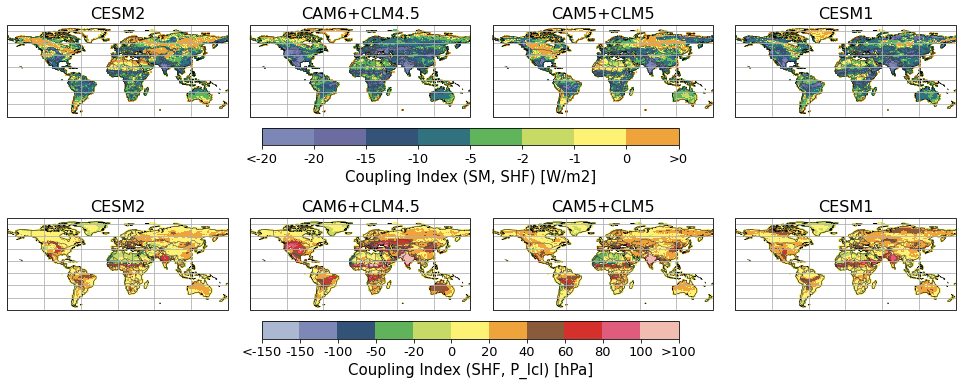

In [11]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[4].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm2*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot CAM6+CLM4.5 panels ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,colorsTerraLeg_clm45,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=15)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=13)  # vertically oriented colorbar


bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[5].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_clm45*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)
# Add colorbar 
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0+0.01, ax_position.y0-0.05, ax_position.width+0.16, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SHF, P_lcl) [hPa]',fontsize=15)
cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=13)  # vertically oriented colorbar


# Additional options 
axs[1].set_title('CAM6+CLM4.5',fontsize=16)
axs[5].set_title('CAM6+CLM4.5',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot CAM5+CLM5 panels ------ 
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cam5,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[6].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cam5*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[2].set_title('CAM5+CLM5',fontsize=16)
axs[6].set_title('CAM5+CLM5',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# ----- Plot CESM1 panels ------ 
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[3].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm1,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[7].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm1*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)

# Additional options 
axs[3].set_title('CESM1',fontsize=16)
axs[7].set_title('CESM1',fontsize=16)
axs[3].gridlines()
axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



## Understanding what this means: Difference plots

In [12]:
atmoDiff_CESM2vCESM1 = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_cesm1  # Impact of upgrading CAM and CLM 
atmoDiff_CESM2vCLM45 = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_clm45  # Impact of upgrading CAM 
atmoDiff_CESM2vCAM5  = AtmoLeg_JJA_cyclic_cesm2 - AtmoLeg_JJA_cyclic_cam5   # Impact of upgrading CLM 

terraDiff_CESM2vCESM1 = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_cesm1 # Impact of upgrading CAM and CLM  
terraDiff_CESM2vCLM45 = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_clm45 # Impact of upgrading CAM 
terraDiff_CESM2vCAM5  = TerraLeg_JJA_cyclic_cesm2 - TerraLeg_JJA_cyclic_cam5  # Impact of upgrading CLM 


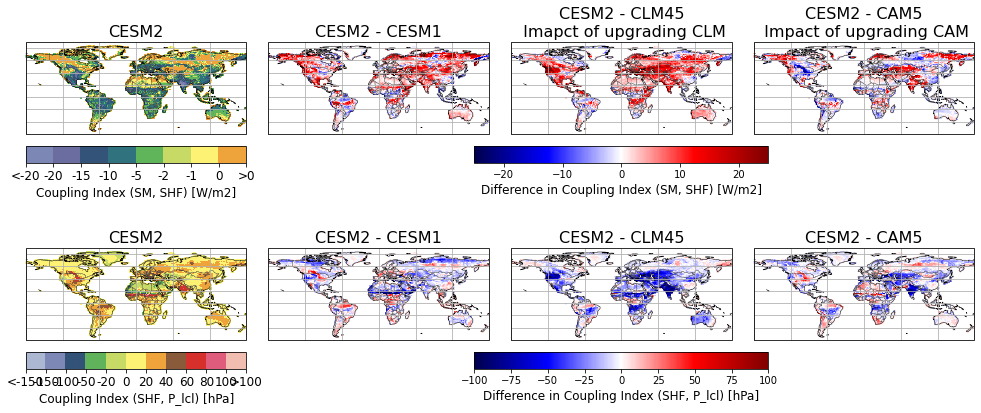

In [14]:
# Set up figure 
fig, axs = plt.subplots(2,4, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


# ----- Plot CESM2 panels ------ 
# Set global-ish extent
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,colorsTerraLeg_cesm2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=12)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=12)  # vertically oriented colorbar


bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[4].pcolormesh(lon_cyclic,lat,colorsAtmoLeg_cesm2*lndMask,norm=norm,
                             cmap=my_cmap_SHFvPlcl,
                             vmin=1,vmax=12)
# Add colorbar 
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)
cbar.ax.set_xticklabels(['<-150','-150','-100','-50','-20','0','20','40','60','80','100','>100'],fontsize=12)  # vertically oriented colorbar


# Additional options 
axs[0].set_title('CESM2',fontsize=16)
axs[4].set_title('CESM2',fontsize=16)
axs[0].gridlines()
axs[4].gridlines()
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')





# ----- Plot difference from CESM1 ------ 
# Set global-ish extent
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCESM1,
                             cmap='seismic',
                             vmin=-25,vmax=25)
contour_plot = axs[5].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCESM1*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[1].set_title('CESM2 - CESM1',fontsize=16)
axs[5].set_title('CESM2 - CESM1',fontsize=16)
axs[1].gridlines()
axs[5].gridlines()
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45
# Set global-ish extent
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[6].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCLM45,
                             cmap='seismic',
                             vmin=-25,vmax=25)
# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in Coupling Index (SM, SHF) [W/m2]',fontsize=12)


contour_plot = axs[6].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCLM45*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Add colorbar 
ax_position = axs[6].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)

# Additional options 
axs[2].set_title('CESM2 - CLM45\n Imapct of upgrading CLM',fontsize=16)
axs[6].set_title('CESM2 - CLM45',fontsize=16)
axs[2].gridlines()
axs[6].gridlines()
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[6].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[6].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot impact of upgrading just CAM------ 
#   ...Diff_CESM2vCAM5
# Set global-ish extent
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[7].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())  


# Contour plots 
contour_plot = axs[3].pcolormesh(lon_cyclic,lat,terraDiff_CESM2vCAM5,
                             cmap='seismic',
                             vmin=-25,vmax=25)

bounds = [1,2,3,4,5,6,7,8,9,10,11,12]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
contour_plot = axs[7].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCAM5*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[3].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
axs[7].set_title('CESM2 - CAM5',fontsize=16)
axs[3].gridlines()
axs[7].gridlines()
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[7].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[7].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# # Add star point 
# axs[6].plot(lon[100],lat[170],'k*',markersize=12,transform=ccrs.PlateCarree())
# axs[7].plot(lon[100],lat[170],'k*',markersize=12,transform=ccrs.PlateCarree())



## Understanding what this means: Are same locations still interesting?

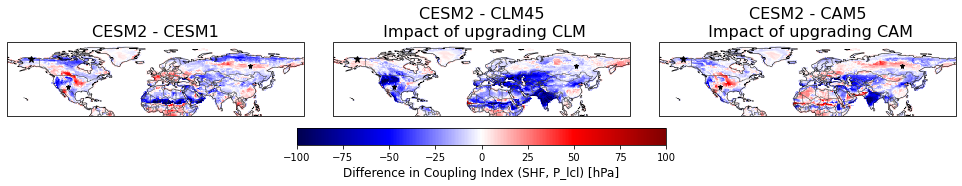

In [27]:
## Atmospheric leg 
# Set up figure 
fig, axs = plt.subplots(1,3, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Zoom in on NH
# axs[0].set_extent([-180,-100,40,90], crs=ccrs.PlateCarree())  
# axs[1].set_extent([-180,-100,40,90], crs=ccrs.PlateCarree())  
# axs[2].set_extent([-180,-100,40,90], crs=ccrs.PlateCarree())  

axs[0].set_extent([-180,180,0,90], crs=ccrs.PlateCarree())  
axs[1].set_extent([-180,180,0,90], crs=ccrs.PlateCarree())  
axs[2].set_extent([-180,180,0,90], crs=ccrs.PlateCarree())  

# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = axs[0].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCESM1*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[0].set_title('CESM2 - CESM1',fontsize=16)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




# ----- Plot impact of upgrading just CAM ------ 
#   ...Diff_CESM2vCLM45  

# Contour plots 
contour_plot = axs[1].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCLM45*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Difference in Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)

# Additional options 
axs[1].set_title('CESM2 - CLM45\n Impact of upgrading CLM',fontsize=16)
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# ----- Plot impact of upgrading just CAM------ 
#   ...Diff_CESM2vCAM5  

# Contour plots 
contour_plot = axs[2].pcolormesh(lon_cyclic,lat,atmoDiff_CESM2vCAM5*lndMask,
                             cmap='seismic',
                             vmin=-100,vmax=100)

# Additional options 
axs[2].set_title('CESM2 - CAM5\n Impact of upgrading CAM',fontsize=16)
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# =========================================================
# --- Add star points
# ========================================================
# Lensk Russia (Not additive): 
ilat = np.where( (lat>=60.2) & (lat<=61.2))[0]
ilon = np.where( (lon>=114.5) & (lon<=115.5))[0]
axs[0].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[1].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[2].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())

# CLM-driven: Santa Fe, NM 
ilat = np.where( (lat>=35.1) & (lat<=36.1))[0]
lonSel = (-105.9378 + 360) % 360
ilon = np.where( (lon>=(lonSel-0.59)) & (lon<=(lonSel+0.59)) )
axs[0].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[1].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())
axs[2].plot(lon[ilon],lat[ilat],'k*',markersize=5,transform=ccrs.PlateCarree())


# CAM-driven 
# Northern Canada 
ilat = np.where( (lat>=68.5) & (lat<=69.5))[0]
lonSel = (-150.8514 + 360) % 360
ilon = np.where( (lon>=(lonSel-0.59)) & (lon<=(lonSel+0.59)) )
axs[0].plot(lon[ilon],lat[ilat],'k*',markersize=7,transform=ccrs.PlateCarree())
axs[1].plot(lon[ilon],lat[ilat],'k*',markersize=7,transform=ccrs.PlateCarree())
axs[2].plot(lon[ilon],lat[ilat],'k*',markersize=7,transform=ccrs.PlateCarree())



In [19]:
# More detail
ilat = np.where( (lat>=68.5) & (lat<=69.5))[0]
lonSel = (-150.8514 + 360) % 360
ilon = np.where( (lon>=(lonSel-0.59)) & (lon<=(lonSel+0.59)) )
print('Point selected: lat = %.2f , lon = %.2f' % (lat[ilat], lon[ilon]))

cesm2 = AtmoLeg_JJA_cyclic_cesm2[ilat,ilon]
cesm1 = AtmoLeg_JJA_cyclic_cesm1[ilat,ilon]
clm45 = AtmoLeg_JJA_cyclic_clm45[ilat,ilon]
cam5  = AtmoLeg_JJA_cyclic_cam5[ilat,ilon]


print('CESM2: %.3f' % cesm2)
print('CESM1: %.3f' % cesm1)
print('CLM45: %.3f' % clm45)
print('CAM5:  %.3f' % cam5)
print()
print('Differences')
print('   CESM2-CESM1: %.3f' % (cesm2-cesm1))
print('   CESM2-CLM45: %.3f' % (cesm2-clm45))
print('   CESM2-CAM5:  %.3f' % (cesm2-cam5))
print()



Point selected: lat = 69.27 , lon = 208.75
CESM2: 6.561
CESM1: 35.150
CLM45: 13.919
CAM5:  28.135

Differences
   CESM2-CESM1: -28.589
   CESM2-CLM45: -7.358
   CESM2-CAM5:  -21.574



In [22]:
# # How much more additive is this...?

# # Consider total change as the sum of (CESM2-CLM45) and (CESM2-CAM5)
# sum_terra = terraDiff_CESM2vCLM45          + terraDiff_CESM2vCAM5
# sum_atmo  = (atmoDiff_CESM2vCLM45*lndMask) + (atmoDiff_CESM2vCAM5*lndMask)

# # How close is that to the CESM2-CESM1 change? 
# #   Take ratio - closer to 1 = nearly additive 
# ratio_terra = sum_terra / terraDiff_CESM2vCESM1 
# ratio_atmo  = sum_atmo / (atmoDiff_CESM2vCESM1*lndMask)
